# Unimodal Varying Request Rate and Average Requested Distance

Varying $\nu$ and $\langle d\rangle$

Efficiency should be constant for lines with
$$\nu\cdot\langle d\rangle = \mathrm{const}$$

-> Expect hyperbolas in Efficiency

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
import scipy.integrate
import pprint
from FindDataFunctions import *

In [11]:
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3Alpha900Beta/"

In [12]:
uni_dirs = getDirs(path, ["reqs", "dist", "drt", "unimodal"], [None, None, "100", None])
display(uni_dirs)

[[25000.0,
  2800.0,
  100.0,
  {'root': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3Alpha900Beta/25000reqs/2800dist/100drt/unimodal',
   'ph_modestats': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3Alpha900Beta/25000reqs/2800dist/100drt/unimodal/ph_modestats.txt',
   'persons': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3Alpha900Beta/25000reqs/2800dist/100drt/unimodal/output_persons.csv.gz',
   'pkm_modestats': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3Alpha900Beta/25000reqs/2800dist/100drt/unimodal/pkm_modestats.txt',
   'trip_success': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3Alpha900Beta/25000reqs/2800dist/100drt/unimodal/trip_success.csv.gz',
   'trips': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3Al

In [13]:
saved_path = os.path.join(path, "saved.pkl")
if os.path.isfile(saved_path):
    df = pd.read_pickle(saved_path)
else:
    cols = ["reqs", "mean_dist", "occupancy", "occupancy_non_idling", "detour", "servability", "req_mean_dist", "drt_wait_time",
        "drt_wait_time_normalized", "drt_distance", "cummulative_dist_drt",
        "cummulative_dist_drt_unshared", "pkm_drt"]
    
    df = pd.DataFrame(np.full((len(uni_dirs),len(cols)), np.nan), columns=cols)

    for i,entry in enumerate(uni_dirs):
        print(*entry[:-1])
        dic = entry[-1]
        row = df.iloc[i]
#         try:
        row.loc["reqs"] = entry[0]
        row.loc["mean_dist"] = entry[1]
        row.loc["occupancy"], _ = getDrtOccupandyAndStandingFrac(dic, False, True)
        row.loc["occupancy_non_idling"], _ = getDrtOccupandyAndStandingFrac(dic, False, False)
        df_detour = getDrtDetours(dic)
        row.loc["detour"] = df_detour["distanceDetour"].mean()
        trip_succ = getTripSuccess(dic)
        row.loc["servability"] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
        df_persons = getPersons(dic)
        row.loc["req_mean_dist"] = df_persons["mean_dist"].mean()
        drt_trips, drt_trips_perperson = getDrtTrips(dic)
        row.loc["drt_wait_time"] = drt_trips_perperson["waitTime"].mean()
        row.loc["cummulative_dist_drt"] = getDrtVehicleDistances(dic).sum()
        row.loc["cummulative_dist_drt_unshared"] = drt_trips["direcTravelDistance_m"].sum()
        df_detour = df_detour.set_index("person")
        row.loc["drt_wait_time_normalized"] = (drt_trips_perperson["waitTime"]/df_detour["unsharedTime"]).mean()
        row.loc["drt_distance"] = drt_trips_perperson["travelDistance_m"].mean()
        _, row.loc["pkm_drt"] = getModeStats(dic, [], ["drt"])
#         except KeyError:
#             print("KeyError")
        print("-----")
    df.to_pickle(saved_path)

In [14]:
effective_dist_mapping = df[["mean_dist","req_mean_dist"]].groupby("mean_dist").mean()["req_mean_dist"]
df["req_mean_dist_av"] = df["mean_dist"].map(effective_dist_mapping)
data = df.pivot(index="reqs", columns="req_mean_dist_av", values=["servability", "drt_wait_time",
                                                       "drt_wait_time_normalized" ,"drt_distance",
                                                       "req_mean_dist", "cummulative_dist_drt",
                                                      "cummulative_dist_drt_unshared", "pkm_drt",
                                                       "occupancy", "occupancy_non_idling", "detour"])

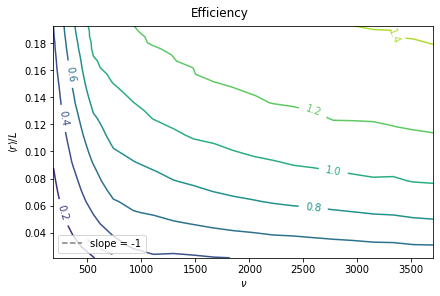

In [21]:
%matplotlib inline

fig, ax = plt.subplots(constrained_layout=True)

sim_timescale = 9*3600 # T_sim [s]
timescale = 10000/(30/3.6) # L/v_drt

# Z = data["cummulative_dist_drt_unshared"]/data["cummulative_dist_drt"]
Z = data["occupancy"]/data["detour"]
x = Z.index.to_numpy()/sim_timescale*timescale
y = Z.columns.to_numpy()/10000
X,Y = np.meshgrid(x, y, indexing='ij')

# im = ax.pcolor(X,Y,Z.to_numpy(), shading='auto', linewidth=0)
im = ax.contour(X,Y,Z.to_numpy())
ax.clabel(im, inline=1, fontsize=10)

x_vals = np.linspace(500, 750, 1000)
b = -1
a = 0.035/x_vals[0]**b
y_vals = a * x_vals**b
ax.plot(x_vals, y_vals, '--', c="grey", label="slope = -1")

# im.set_edgecolor('face')
# plt.colorbar(im, label="Efficiency")
ax.set_xlabel(r"$\nu$")
ax.set_ylabel(r"$\langle r\rangle/L$")
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.legend(loc="lower left")
fig.suptitle("Efficiency")

# fig.savefig("figures/VaryNuAvDistUnimodalLogLog.jpg", dpi=300)

plt.show()